In [8]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('kaggle_stock_data.csv')
df.head()

,Unnamed: 0,Instrument,Date,Price High,Price Close,Price Open,Volume
0,0,CBKG.DE,2019-01-02T00:00:00Z,5.804,5.765,5.782,7221471.0
1,1,CBKG.DE,2019-01-03T00:00:00Z,5.950,5.802,5.748,8064658.0
2,2,CBKG.DE,2019-01-04T00:00:00Z,6.168,6.143,5.890,8772521.0
3,3,CBKG.DE,2019-01-07T00:00:00Z,6.249,6.182,6.242,6781840.0
4,4,CBKG.DE,2019-01-08T00:00:00Z,6.390,6.330,6.172,8472530.0


In [3]:
df.isnull().sum()

Unnamed: 0         0
Instrument         0
Date           37938
Price High     38712
Price Close    38679
Price Open     39511
Volume         57783
dtype: int64

In [4]:
df.shape

(501625, 7)

In [7]:
df = df.dropna()
df.shape

(404364, 7)

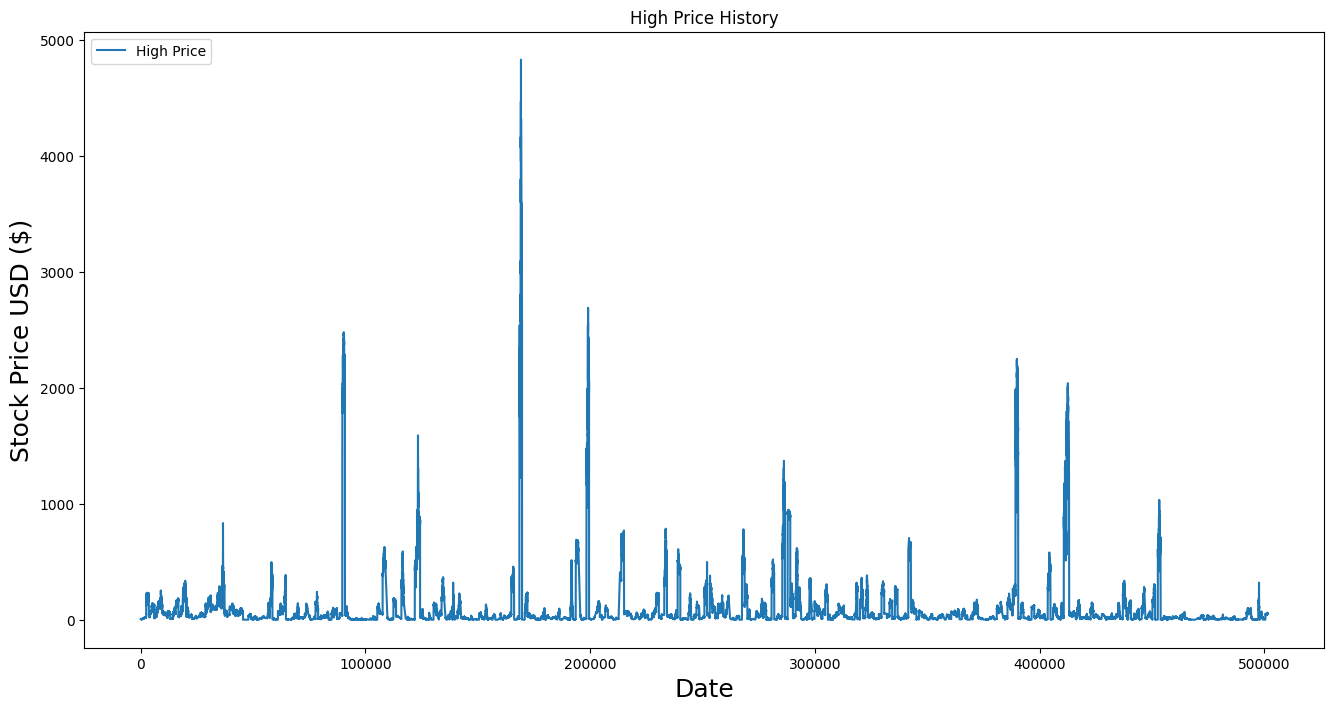

In [18]:
plt.figure(figsize=(16,8))
plt.title('High Price History')
plt.plot(df['Price High'], label='High Price')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Stock Price USD ($)', fontsize=18)
plt.legend(loc='upper left')
plt.show()



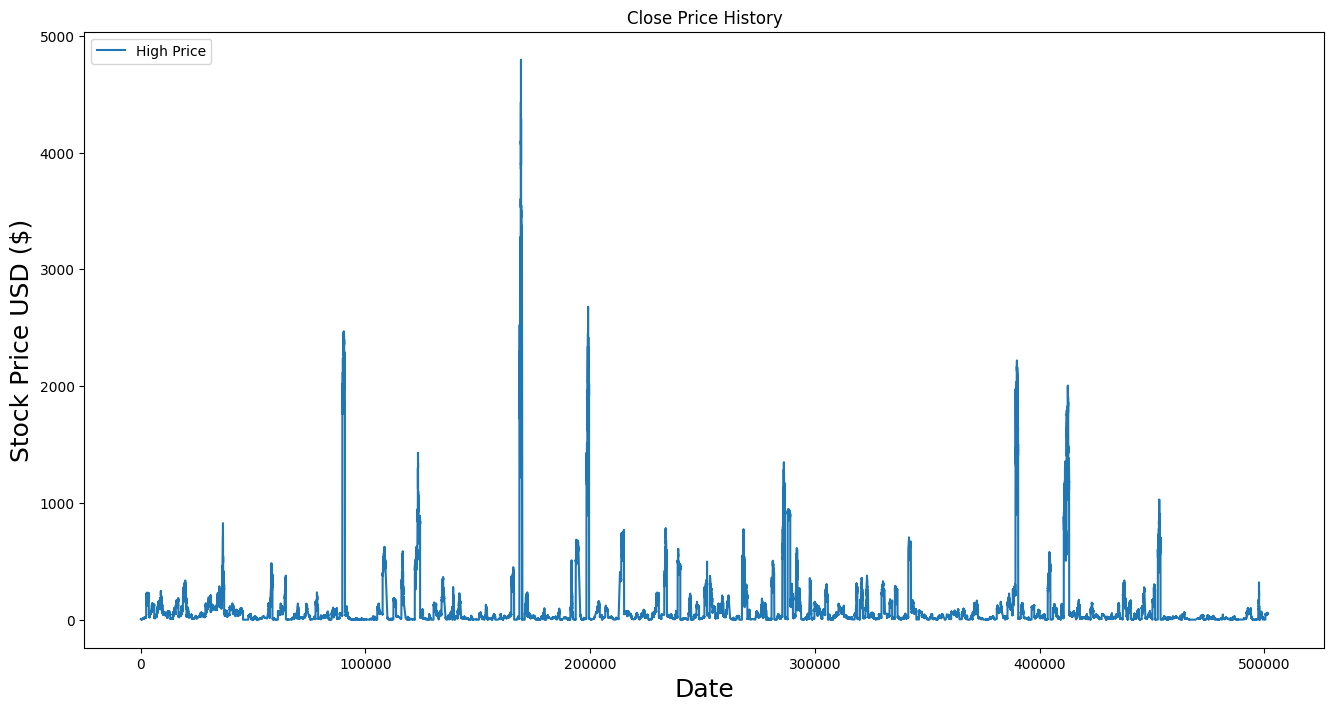

In [21]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Price Close'], label='High Price')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Stock Price USD ($)', fontsize=18)
plt.legend(loc='upper left')
plt.show()

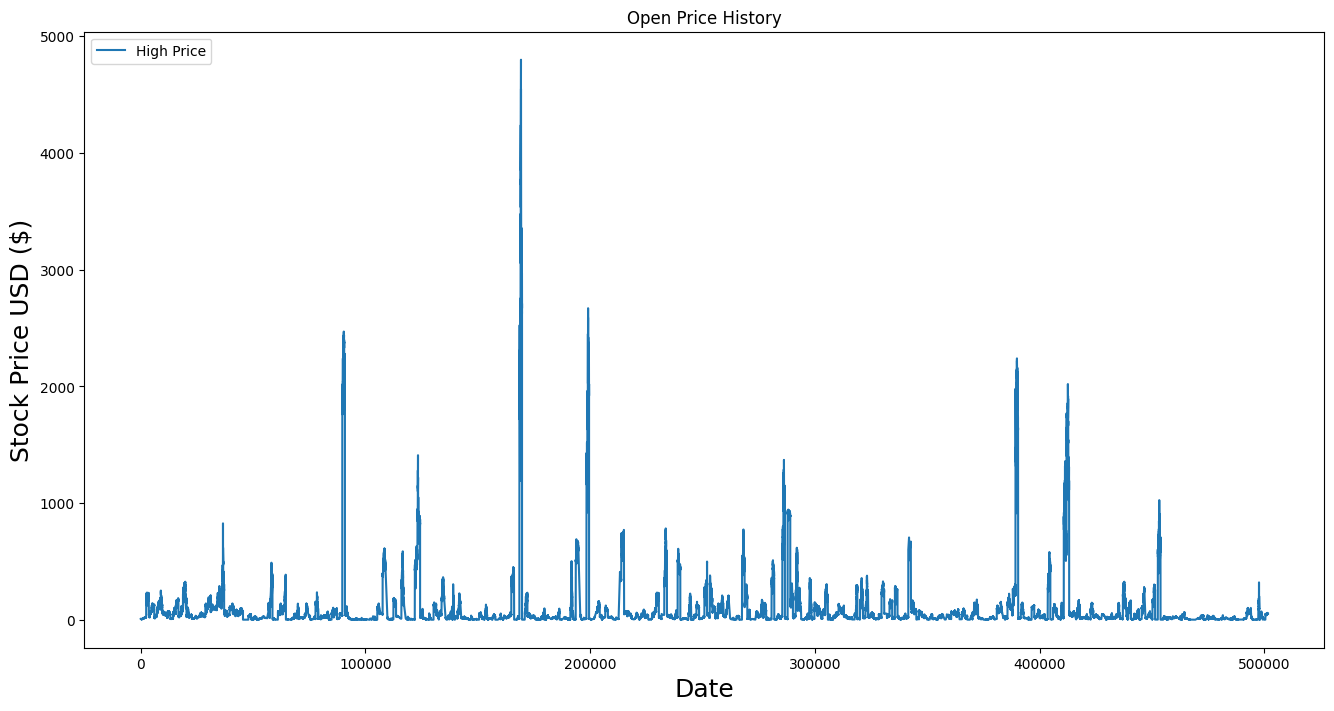

In [22]:
plt.figure(figsize=(16,8))
plt.title('Open Price History')
plt.plot(df['Price Open'], label='High Price')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Stock Price USD ($)', fontsize=18)
plt.legend(loc='upper left')
plt.show()

In [24]:
df['Price High'].max()


4830.0

In [25]:
df.nlargest(3, 'Price High')



,Unnamed: 0,Instrument,Date,Price High,Price Close,Price Open,Volume
169193,169193,INRN.S,2021-11-09T00:00:00Z,4830.0,4795.0,4725.0,979.0
169194,169194,INRN.S,2021-11-10T00:00:00Z,4820.0,4725.0,4800.0,730.0
169191,169191,INRN.S,2021-11-05T00:00:00Z,4795.0,4630.0,4720.0,1484.0


In [30]:
df['rendimiento_porinstrumento'] = df['Price Close'] - df['Price Open']
df.nlargest(3, 'rendimiento_porinstrumento')


,Unnamed: 0,Instrument,Date,Price High,Price Close,Price Open,Volume,rendimiento_porinstrumento
169537,169537,INRN.S,2023-03-17T00:00:00Z,3135.0,3115.0,2870.0,3465.0,245.0
169629,169629,INRN.S,2023-08-02T00:00:00Z,2945.0,2915.0,2685.0,2254.0,230.0
169213,169213,INRN.S,2021-12-07T00:00:00Z,4325.0,4325.0,4105.0,1418.0,220.0


In [32]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import numpy as np

class StockPredictor:
    def __init__(self, data):
        self.data = data
        self.scaler = MinMaxScaler(feature_range=(0,1))
        self.model = None
        self.x_train = None
        self.y_train = None
        self.training_data_len = None
        
    def prepare_data(self):
        # Seleccionar solo el precio de cierre
        data = self.data.filter(['Price Close'])
        dataset = data.values

        # Escalar los datos
        scaled_data = self.scaler.fit_transform(dataset)

        # Definir el número de filas para entrenar el modelo
        self.training_data_len = int(len(dataset) * 0.8)

        # Crear el conjunto de datos de entrenamiento
        train_data = scaled_data[0:self.training_data_len, :]
        self.x_train = []
        self.y_train = []

        # Crear los datos de entrenamiento
        for i in range(60, len(train_data)):
            self.x_train.append(train_data[i-60:i, 0])
            self.y_train.append(train_data[i, 0])

        # Convertir x_train y y_train a matrices numpy
        self.x_train, self.y_train = np.array(self.x_train), np.array(self.y_train)

        # Reshape data
        self.x_train = np.reshape(self.x_train, (self.x_train.shape[0], self.x_train.shape[1], 1))

    def build_model(self):
        # Construir el modelo LSTM
        self.model = Sequential()
        self.model.add(LSTM(32, return_sequences=True, input_shape=(self.x_train.shape[1], 1)))
        self.model.add(LSTM(16, return_sequences=False))
        self.model.add(Dense(8))
        self.model.add(Dense(1))

        # Compilar el modelo
        self.model.compile(optimizer='adam', loss='mean_squared_error')

    def train_model(self):
        # Entrenar el modelo
        self.model.fit(self.x_train, self.y_train, batch_size=32, epochs=10, verbose=0)

    def predict(self):
        # Crear el conjunto de datos de prueba
        test_data = self.scaler.transform(self.data.filter(['Price Close']).values[self.training_data_len - 60:, :])
        x_test = []

        # Crear los datos de prueba
        for i in range(60, len(test_data)):
            x_test.append(test_data[i-60:i, 0])

        # Convertir los datos a una matriz numpy
        x_test = np.array(x_test)

        # Reshape data
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

        # Obtener los valores de precios predichos por el modelo
        predictions = self.model.predict(x_test)
        predictions = self.scaler.inverse_transform(predictions)

        # Obtener el error cuadrático medio (RMSE)
        rmse = np.sqrt(np.mean(predictions - self.data.filter(['Price Close']).values[self.training_data_len:, :])**2)
        print(rmse)

        # Plotear los datos
        train = self.data.filter(['Price Close'])[:self.training_data_len]
        valid = self.data.filter(['Price Close'])[self.training_data_len:]
        valid['Predictions'] = predictions

        plt.figure(figsize=(16,8))
        plt.title('Model')
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Close Price USD ($)', fontsize=18)  
        plt.plot(train['Price Close'])
        plt.plot(valid[['Price Close', 'Predictions']])
        plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')        
        plt.show()


stock_predictor = StockPredictor(df)
stock_predictor.prepare_data()
stock_predictor.build_model()
stock_predictor.train_model()
stock_predictor.predict()



  4321/323431 [..............................] - ETA: 1:32:50 - loss: 4.8636e-04

KeyboardInterrupt: 